In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
writer = SummaryWriter('runs/cifar10_origin')

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


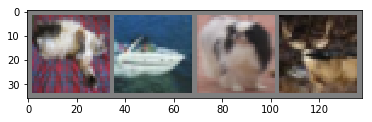

  cat  ship   dog  deer


In [9]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.feature_map_conv1 = None
        self.feature_map_conv2 = None

    def forward(self, x):
        x = self.conv1(x)
        self.feature_map_conv1 = x
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        self.feature_map_conv2 = x
        x = self.pool(F.relu(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda")

print(device)
net = Net()
net.to(device)

cuda


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            writer.add_scalar('training loss 4 epoch', running_loss / 2000,
                              epoch * len(trainloader) + i)
            
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.233
[1,  4000] loss: 1.891
[1,  6000] loss: 1.673
[1,  8000] loss: 1.590
[1, 10000] loss: 1.519
[1, 12000] loss: 1.484
[2,  2000] loss: 1.411
[2,  4000] loss: 1.371
[2,  6000] loss: 1.364
[2,  8000] loss: 1.327
[2, 10000] loss: 1.312
[2, 12000] loss: 1.303
[3,  2000] loss: 1.232
[3,  4000] loss: 1.218
[3,  6000] loss: 1.215
[3,  8000] loss: 1.202
[3, 10000] loss: 1.204
[3, 12000] loss: 1.192
[4,  2000] loss: 1.114
[4,  4000] loss: 1.116
[4,  6000] loss: 1.104
[4,  8000] loss: 1.124
[4, 10000] loss: 1.096
[4, 12000] loss: 1.136
Finished Training


In [13]:
feature_map_conv1_grid = torchvision.utils.make_grid(net.feature_map_conv1[0].unsqueeze(dim=1),normalize=True)
writer.add_image('feature_map_conv1', feature_map_conv1_grid)
feature_map_conv2_grid = torchvision.utils.make_grid(net.feature_map_conv2[0].unsqueeze(dim=1),normalize=True)
writer.add_image('feature_map_conv2', feature_map_conv2_grid)

In [20]:
PATH = './cifar10_origin.pth'
torch.save(net.state_dict(), PATH)

In [27]:
def test(net, weight_path, trainloader, testloader):
    net.load_state_dict(torch.load(weight_path))
    device = torch.device("cuda")
    net.to(device)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50000 train images: %d %%' % (
        100 * correct / total))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [28]:
net = Net()
test(net, PATH, trainloader, testloader)

Accuracy of the network on the 50000 train images: 61 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 55 %
Accuracy of   car : 76 %
Accuracy of  bird : 52 %
Accuracy of   cat : 32 %
Accuracy of  deer : 65 %
Accuracy of   dog : 52 %
Accuracy of  frog : 52 %
Accuracy of horse : 67 %
Accuracy of  ship : 81 %
Accuracy of truck : 39 %
